In [1]:
!pwd

/Users/macbook/divtel


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *


import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


The Idea is to have two notebooks, one for MST configuration confronting just one altitude and the other for them changing with zenith
This one should be just for one altitude 

## LOAD CTA CONFIG

In [3]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-06T14:49:18.814


In [4]:
# Note that if the radius is in meters, 
# you can set LoadConfig(file, radius="meters")
# defalut is in degrees

array = LoadConfig("/Users/macbook/divtel/ParanalArrayPositions_divProd6.txt", frame=cta)
full_array= LoadConfig("/Users/macbook/divtel/Paranal_only_MST.txt", frame=cta)

## Check configuration table

In [5]:
array.table.units = "deg"
array.table
full_array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,rad,rad,rad,m,m,rad2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,0.0,24.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,22.65
2,0.0,151.0,25.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,152.67
3,0.0,-151.0,31.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,152.68
4,150.0,75.0,21.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,188.09
5,150.0,-75.0,26.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,187.98
6,150.0,240.0,24.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,295.50
7,150.0,-240.0,30.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,295.49
8,313.0,0.0,19.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,335.47


In [6]:
table=array.table

## Check the telescope spatial distribution
This is useful to pick the groups

In [7]:
array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,-20.0,-65.0,34.0,0.000,0.000,90.000,28.000,2.150,14.536,1.000,-0.000,0.000,66.52
2,80.0,0.0,29.0,0.000,0.000,90.000,28.000,2.150,14.536,1.000,-0.000,0.000,86.67
3,-20.0,65.0,31.0,0.000,0.000,90.000,28.000,2.150,14.536,1.000,-0.000,0.000,66.37
4,-120.0,0.0,33.0,0.000,0.000,90.000,28.000,2.150,14.536,1.000,-0.000,0.000,113.39
5,0.0,0.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,8.55
6,0.0,151.0,25.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,151.21
7,0.0,-151.0,31.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,151.16
8,150.0,75.0,21.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,173.90


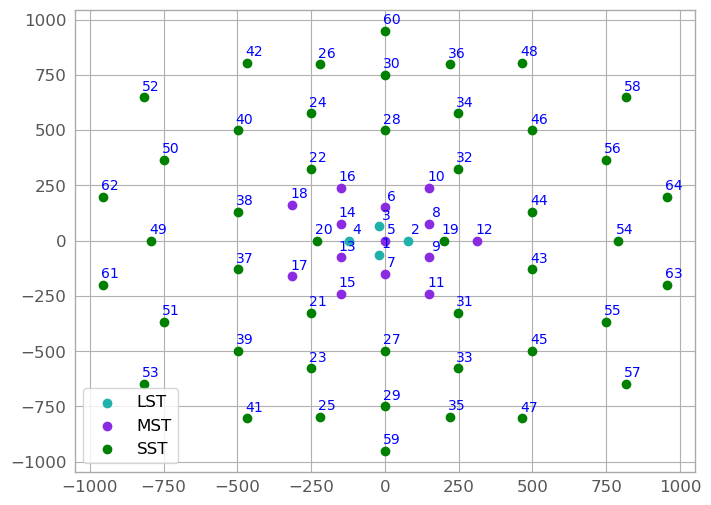

In [8]:
# Loop through all the telescopes
#for fov in array.table["fov"]:
#    print(fov)
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
for i in range(len(array.table)):
    plt.scatter(array.table['x'][i], array.table['y'][i], c=colors[i], label=fov_labels[colors[i]])

    # Annotate each point with the telescope ID
    #matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
#Annotate the point xy with text text.
#In the simplest form, the text is placed at xy.
    plt.annotate(str(array.table["id"][i]),
                 (array.table['x'][i], array.table['y'][i]),  # Point position
                 textcoords="offset points",  # Text position relative to the point
                 xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
                 ha='center', fontsize=10, color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
#handles, labels like this is doing
    #plt.gca() gets the current Axes object, which is where your plot is
    #.get_legend_handles_labels()
        #handles: Returns a list of the graphical elements (e.g., lines, scatter plot points) that would appear in the legend.
        # labels: Returns the text labels associated with each graphical element in handles

by_label = dict(zip(labels, handles))  # Remove duplicate labels, the dictionary by the structure takes out the double 
plt.legend(by_label.values(), by_label.keys())
#by_label.values This is pulling out the unique graphical elements
# by_label.keys  This is retrieving the unique text 
plt.savefig("./different_telescopes.png", dpi=300, bbox_inches="tight")
plt.show() 

## Check the hyper field of view (hFoV)

This is the whole telescope array hFoV maybe? (ask)

In [9]:
array.hFoV(m_cut=3) 

64it [00:09,  6.91it/s]


(62.238869377690584, 57.415086388537716)

In [10]:
#array.hFoV(m_cut=3)

## Grouping telescopes

In [16]:
sub_groups={'1':[7,8,11], 
            '2': [5,13,16,18],
            '3': [14,15,17], 
            '4': [6,10,12,9]}
sub_groups_2 = {'1':[18,17,16,14], 
                '2': [13,15,5,7],
                '3': [6,8,10],
                '4': [9,11,12]
              }
#sub_groups_2={'1':[18,14,13,17],
#             '2':[7,11,15],
#             '3':[5,8,9,12],
#            '4':[16,6,10]}


second_best={'1':[16,18,13], 
            '2': [14,17,15],
            '3': [5,6,10,9], 
            '4': [7,8,11,12]}
#overposition = {'1':[18,10,12,13], 
#                '2':[14,15,17],
#                '3': [6,7,9,11],
#                '4': [16,8,5]
#              }
#sub_groups_3={'1':[16,9,17],
#             '2':[10,14,18],
#             '3':[6,8,7,12],
#The configuration 4 doesnt work that well 
sub_groups_4={'1':[16,7,17],
             '2':[10,14,18,12],
             '3':[6,8,9],
             '4':[13,5,11,15]}


In [12]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [13]:
tel_group_2, labels_2, number_of_telescopes_subarray_2 =array.group_by(sub_groups_2)
#tel_group_3, labels_3 = group_by(array, group=only_MST)

In [17]:
tel_group, labels, number_of_telescopes_subarray_1 =array.group_by(sub_groups)

In [18]:
tel_group_3, labels_3, number_of_telescopes_subarray_3 =array.group_by(second_best)

In [19]:
# Step 2: Create new telescope list with center of gravity
new_telescopes = create_new_group_list(tel_group)
new_telescopes_2 = create_new_group_list(tel_group_2)
new_telescopes_3 = create_new_group_list(tel_group_3)

#Why are you creating an extra telescope?


<TableGroups indices=[ 0 50 53 57 60 64]>
28.0 2.15
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
28.0 2.15
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
28.0 2.15
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85


In [20]:
#del new_telescopes[0]# Step 3: Output the result
#for telescope in new_telescopes:
#    print(telescope)
del new_telescopes[0]#No clue why it keeps on putting me an extra telescope...soooo... I deleted it... I will find out why
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [21]:
del new_telescopes_2[0]
for telescope in new_telescopes_2:
    print(telescope)


[-231.5, 78.75, 30.12, 16.0, 3.85]
[-75.0, -116.5, 30.38, 16.0, 3.85]
[100.0, 155.33, 23.33, 16.0, 3.85]
[204.33, -105.0, 25.0, 16.0, 3.85]


In [22]:
del new_telescopes_3[0]
for telescope in new_telescopes_3:
    print(telescope)


[-204.33, 109.0, 28.5, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[75.0, 79.0, 24.75, 16.0, 3.85]
[153.25, -79.0, 25.25, 16.0, 3.85]


In [23]:
# Define the file path where you want to save the output
output_file_path = './subarray_1_2_SOUTH.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./subarray_1_2_SOUTH.txt


In [24]:
range(len(array.telescopes))

range(0, 64)

In [25]:
# Define the file path where you want to save the output
output_file_path_2 = 'subarray_2_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_2, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_2):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_2}")


New telescope data has been written to subarray_2_SOUTH.txt


In [26]:
# Define the file path where you want to save the output
output_file_path_3 = 'subarray_3_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_3):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_3}")


New telescope data has been written to subarray_3_SOUTH.txt


## SANITY CHECK

In [28]:
#array_3.table

# THE FIELD OF VIEW

## GRAPHING MULTIPLICITY AND FOV to understand what is going on 

In [39]:
array= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)


In [40]:
array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,rad,rad,rad,m,m,rad2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,100.0,-105.33,27.33,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,156.04
2,-153.25,81.75,27.38,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,158.82
3,-204.33,-109.0,33.83,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,202.35
4,153.25,79.0,23.5,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,201.79


In [41]:
full_array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,0.0,24.0,-0.000,68.724,21.276,16.000,3.850,46.707,0.363,0.000,0.932,22.65
2,0.0,151.0,25.0,337.395,67.152,22.848,16.000,3.850,46.707,0.358,0.149,0.922,152.67
3,0.0,-151.0,31.0,22.605,67.283,22.717,16.000,3.850,46.707,0.357,-0.148,0.922,152.68
4,150.0,75.0,21.0,351.677,60.833,29.167,16.000,3.850,46.707,0.482,0.071,0.873,188.09
5,150.0,-75.0,26.0,8.323,60.964,29.036,16.000,3.850,46.707,0.480,-0.070,0.874,187.98
6,150.0,240.0,24.0,334.914,58.709,31.291,16.000,3.850,46.707,0.470,0.220,0.855,295.50
7,150.0,-240.0,30.0,25.086,58.872,31.128,16.000,3.850,46.707,0.468,-0.219,0.856,295.49
8,313.0,0.0,19.0,-0.000,53.893,36.107,16.000,3.850,46.707,0.589,0.000,0.808,335.47


In [42]:
array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,rad,rad,rad,m,m,rad2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,100.0,-105.33,27.33,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,156.04
2,-153.25,81.75,27.38,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,158.82
3,-204.33,-109.0,33.83,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,202.35
4,153.25,79.0,23.5,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,201.79


In [90]:
full_array.divergent_pointing(0.02, az=0,alt=70)

In [44]:
full_array.hFoV(m_cut=3)[0]

14it [00:01,  7.35it/s]


0.4589887122248568

In [45]:
full_array.hFoV()[0]

14it [00:01,  7.42it/s]


390.2715450231926

14it [00:01,  7.11it/s]
14it [00:01,  7.10it/s]


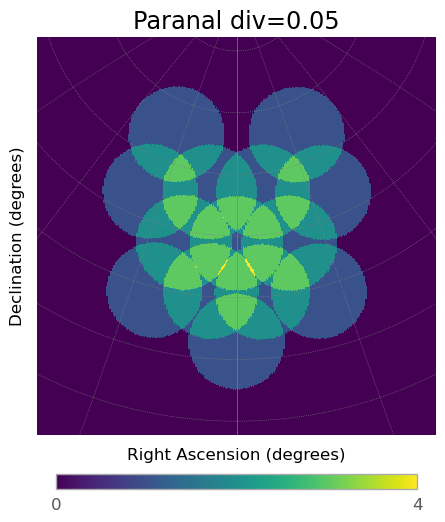

In [112]:
full_array.divergent_pointing(0.05, az=0,alt=70)
full_array.multiplicity_plot()

-6.283185307179586 rad
-6.278767501221106 rad
-0.004417805958480514 rad
-6.280981349736347 rad
-0.002203957443239535 rad
-6.27613274887233 rad
-0.007052558307256707 rad
-6.283185307179586 rad
-0.0021846975524240086 rad
-6.281000609627162 rad
-0.006990929398609236 rad
-6.2761943777809766 rad
-0.0046966195813640255 rad
-6.278488687598222 rad


14it [00:02,  6.80it/s]
14it [00:01,  7.04it/s]


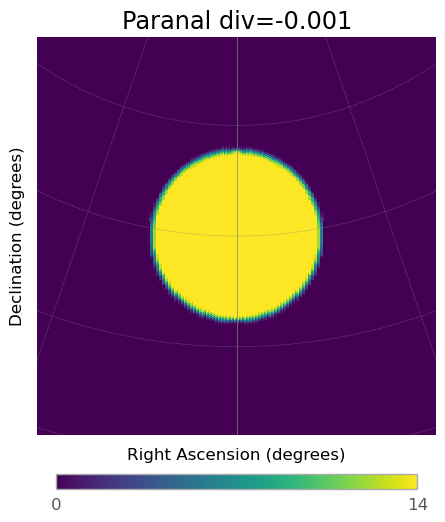

In [138]:
full_array.divergent_pointing(-0.001, az=0,alt=70)
full_array.multiplicity_plot()

-626.0 -626.0 51.24
-626.0 -626.0 1303.24
-626.0 626.0 51.24
-626.0 626.0 1303.24
626.0 -626.0 51.24
626.0 -626.0 1303.24
626.0 626.0 51.24
626.0 626.0 1303.24


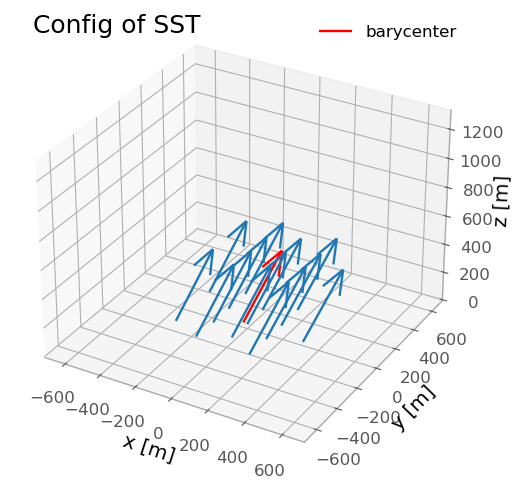

In [139]:
#array_alt_1.display("xyz")

ax = full_array.display("xyz")



#ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.text2D(0.05, 0.95, "Config of SST ", 
          transform=ax.transAxes, fontsize=18)



plt.show()

In [47]:
div=[]

div=np.linspace(0,0.1, 15)
div_no_saturation_full_array=[]#So we can get an array with all the divergence in the full_array
div_no_saturation_sub_1=[]
div_no_saturation_sub_2=[]
div_no_saturation_sub_3=[]


In [48]:
FoV_full_array=[]
multiplicity_full_array=[]
for divergence in div:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV(m_cut=3)[0] != 0: #To get the no saturation
        FoV=full_array.hFoV(m_cut=3)[0]
        multiplicity=full_array.hFoV(m_cut=3)[1]
        FoV_full_array.append(FoV)
        multiplicity_full_array.append(multiplicity)
        div_no_saturation_full_array.append(divergence)

14it [00:01,  7.39it/s]
14it [00:01,  7.27it/s]
14it [00:01,  7.31it/s]
14it [00:01,  7.24it/s]
14it [00:01,  7.31it/s]
14it [00:01,  7.30it/s]
14it [00:01,  7.28it/s]
14it [00:01,  7.25it/s]
14it [00:01,  7.08it/s]
14it [00:01,  7.31it/s]
14it [00:01,  7.34it/s]
14it [00:01,  7.29it/s]
14it [00:01,  7.29it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.30it/s]
14it [00:01,  7.20it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.20it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.26it/s]
14it [00:02,  6.82it/s]
14it [00:01,  7.25it/s]
14it [00:02,  6.76it/s]
14it [00:02,  4.73it/s]
14it [00:01,  7.15it/s]
14it [00:01,  7.13it/s]
14it [00:01,  7.11it/s]
14it [00:01,  7.22it/s]
14it [00:01,  7.24it/s]
14it [00:01,  7.23it/s]
14it [00:01,  7.26it/s]


In [49]:
div_no_saturation_full_array

[0.0,
 0.0071428571428571435,
 0.014285714285714287,
 0.02142857142857143,
 0.028571428571428574,
 0.03571428571428572,
 0.04285714285714286,
 0.05]

In [50]:
array.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,rad,rad,rad,m,m,rad2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,100.0,-105.33,27.33,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,156.04
2,-153.25,81.75,27.38,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,158.82
3,-204.33,-109.0,33.83,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,202.35
4,153.25,79.0,23.5,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,201.79


In [51]:
FoV_array_complete=[]
multiplicity_array_complete=[]
FoV_array=[]#This will be the one without saturation
multiplicity_array=[] #This will be the one without saturation
for divergence in div:
    array.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]
    FoV_array_complete.append(FoV)
    multiplicity_array_complete.append(multiplicity)
    

4it [00:00,  7.29it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.14it/s]
4it [00:00,  5.71it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.09it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.20it/s]
4it [00:00,  6.98it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.17it/s]
4it [00:00,  6.65it/s]
4it [00:00,  7.34it/s]
4it [00:00,  6.95it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.18it/s]
4it [00:00,  7.05it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.07it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.16it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.43it/s]
4it [00:00,  6.95it/s]
4it [00:00,  7.42it/s]


In [52]:

FoV_array=[]#This will be the one without saturation
multiplicity_array=[] #This will be the one without saturation
div_no_saturation_sub_1=[]
for i in range(np.size(FoV_array_complete)-1):
        if np.round(FoV_array_complete[i+1])!=np.round(FoV_array_complete[i]):
            FoV_array.append(FoV_array_complete[i])
            multiplicity_array.append(multiplicity_array_complete[i])
print(np.size(FoV_array))
div_stop=np.size(FoV_array)
div_no_saturation_sub_1=div[:div_stop] 
print(FoV_array)

10
[46.42342975074266, 62.606060347470475, 80.2967967129371, 99.11533391415622, 118.68136701814156, 138.99489602489308, 158.6658408345298, 170.53397753634394, 178.12696223286372, 183.76596641162627]


In [53]:
div_no_saturation_sub_1

array([0.        , 0.00714286, 0.01428571, 0.02142857, 0.02857143,
       0.03571429, 0.04285714, 0.05      , 0.05714286, 0.06428571])

In [54]:
array_2.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,rad,rad,rad,m,m,rad2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,-231.5,78.75,30.12,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,243.03
2,-75.0,-116.5,30.38,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,140.96
3,100.0,155.33,23.33,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,182.44
4,204.33,-105.0,25.0,0.000,0.000,1.571,16.000,1.077,0.014,1.000,-0.000,0.000,231.67


In [55]:
FoV_array_complete_2=[]
multiplicity_array_complete_2=[]
FoV_array_2=[]#This will be the one without saturation
multiplicity_array_2=[] #This will be the one without saturation
for divergence in div:
    array_2.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0]
    multiplicity=array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1]
    FoV_array_complete_2.append(FoV)
    multiplicity_array_complete_2.append(multiplicity)
    
FoV_array_2=[]#This will be the one without saturation
multiplicity_array_2=[] #This will be the one without saturation
div_no_saturation_sub_2=[]


4it [00:00,  7.31it/s]
4it [00:00,  7.04it/s]
4it [00:00,  7.29it/s]
4it [00:00,  6.89it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.16it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.16it/s]
4it [00:00,  7.00it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.30it/s]
4it [00:00,  6.95it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.23it/s]
4it [00:00,  6.75it/s]
4it [00:00,  7.05it/s]
4it [00:00,  7.14it/s]
4it [00:00,  7.28it/s]


In [56]:

for i in range(np.size(FoV_array_complete_2)-1):
        if np.round(FoV_array_complete_2[i+1])!=np.round(FoV_array_complete_2[i]):
            FoV_array_2.append(FoV_array_complete_2[i])
            multiplicity_array_2.append(multiplicity_array_complete_2[i])
print(np.size(FoV_array_2))
div_stop_2=np.size(FoV_array_2)
div_no_saturation_sub_2=div[:div_stop_2] 
print(FoV_array_2)

8
[46.42342975074266, 65.1895110991361, 85.62106577474543, 107.87546133604778, 130.89046676332273, 154.43003071885468, 174.55996424071625, 184.8019695049338]


In [57]:
# SUBARRAY 3 

FoV_array_complete_3=[]
multiplicity_array_complete_3=[]
FoV_array_3=[]#This will be the one without saturation
multiplicity_array_3=[] #This will be the one without saturation
for divergence in div:
    array_3.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0]
    multiplicity=array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1]
    FoV_array_complete_3.append(FoV)
    multiplicity_array_complete_3.append(multiplicity)
    
FoV_array_3=[]#This will be the one without saturation
multiplicity_array_3=[] #This will be the one without saturation
div_no_saturation_sub_3=[]

for i in range(np.size(FoV_array_complete_3)-1):
        if np.round(FoV_array_complete_3[i+1])!=np.round(FoV_array_complete_3[i]):
            FoV_array_3.append(FoV_array_complete_3[i])
            multiplicity_array_3.append(multiplicity_array_complete_3[i])
print(np.size(FoV_array_3))
div_stop_3=np.size(FoV_array_3)
div_no_saturation_sub_3=div[:div_stop_3] 
print(FoV_array_3)

4it [00:00,  7.40it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.13it/s]
4it [00:00,  6.98it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.10it/s]
4it [00:00,  7.00it/s]
4it [00:00,  7.05it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.33it/s]
4it [00:00,  6.69it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.24it/s]
4it [00:00,  6.60it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.07it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.06it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.07it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.40it/s]

11
[46.42342975074266, 63.235530581378846, 81.45082547510245, 100.57098383006934, 120.95008265285298, 141.19804184357238, 158.4953593128463, 170.38972394107327, 177.3663523668911, 181.2218575495799, 183.88399208048406]


In [58]:
print(len(div), len(FoV_full_array), len(FoV_array))

15 8 10


In [59]:
## First to start understanding what is going on I wanted to graph in the 4 plots together 

In [60]:
FoV_array

[46.42342975074266,
 62.606060347470475,
 80.2967967129371,
 99.11533391415622,
 118.68136701814156,
 138.99489602489308,
 158.6658408345298,
 170.53397753634394,
 178.12696223286372,
 183.76596641162627]

In [61]:
FoV_array_2

[46.42342975074266,
 65.1895110991361,
 85.62106577474543,
 107.87546133604778,
 130.89046676332273,
 154.43003071885468,
 174.55996424071625,
 184.8019695049338]

In [62]:
number_of_telescopes_subarray_2

[4, 4, 3, 3]

In [63]:
number_of_telescopes_subarray_3

[3, 3, 4, 4]

## PENSAR COMO AUTOMIZAR LO SIGUIENTE EL FOV CHE STUDIO TIENE QUE SER SI O SI DEL FULL ARRAY CON EL MINIMO DEL ARRAY DE TELESCOPIOS QUE TENGO PRARA PODER CONFRONTAR MEJOR. En cambio no poner ningun limite para los subarrays

In [64]:
number_of_telescopes_subarray_1

[3, 4, 3, 4]

# hFoV and multiplicities graphs COMPLETE!
Meaning no ranges, we see the whole thing even when we loose focus

In [65]:
#mask[:100]
multiplicity_full_array

[14.0,
 10.466622162883844,
 8.222538958570885,
 6.682948333627226,
 5.460813405480887,
 4.5971746575342465,
 4.021469465648855,
 4.0]

In [66]:
 FoV_full_array

[46.42342975074266,
 58.934150649671615,
 69.00567439220562,
 74.36928534363324,
 75.12989520960585,
 61.26843610041517,
 27.486866880665712,
 0.4589887122248568]

plt.plot(div_no_saturation_sub_1, multiplicity_array_2[:10]/multiplicity_array)
plt.title('Multiplicity Plot')
plt.show()

## SHOWING WHAT HAPPENS RUGHT AFTER 0.05 

array.divergent_pointing(div=0.05, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.05, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.05, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)
array_4.multiplicity_plot(number_of_telescopes_subarray_4)
array_4.divergent_pointing(div=0.05, az=0, alt=70)

array.divergent_pointing(div=0.06, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_3.divergent_pointing(div=0.06, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

# MULTIPLICITY PLOTS WITH THE RANGES 

In [67]:
##Puting the stop to when we expect the divergence to be too much for us to have cross overs between the different FoV of the single telescopes
stop=0.036 #From what we saw in the previous slides 
stop_div=[]
for div in div_no_saturation_sub_1:
    print(np.round(div,3))
    #print("stop is:")
    #print(stop)
    if np.round(div, 3)  <= stop:
        print(div)
        stop_div.append(div)
array_slice_stop = np.size(stop_div) #This is to slice the array

0.0
0.0
0.007
0.0071428571428571435
0.014
0.014285714285714287
0.021
0.02142857142857143
0.029
0.028571428571428574
0.036
0.03571428571428572
0.043
0.05
0.057
0.064


14it [00:01,  7.26it/s]
14it [00:01,  7.07it/s]


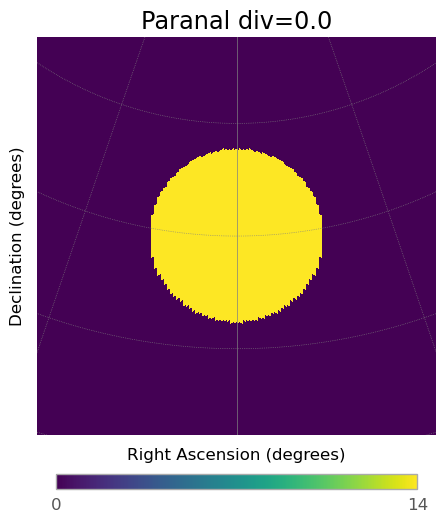

14it [00:01,  7.10it/s]
14it [00:01,  7.07it/s]


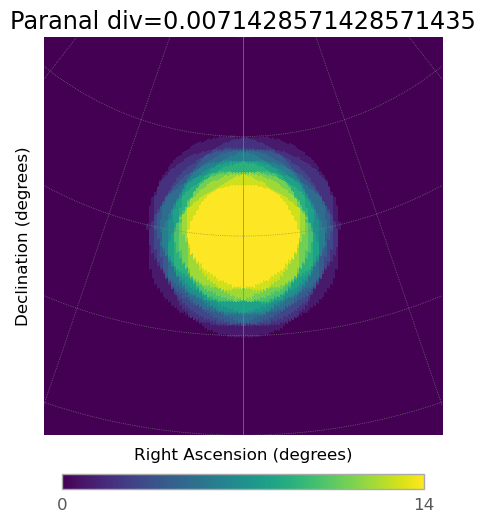

14it [00:01,  7.27it/s]
14it [00:01,  7.04it/s]


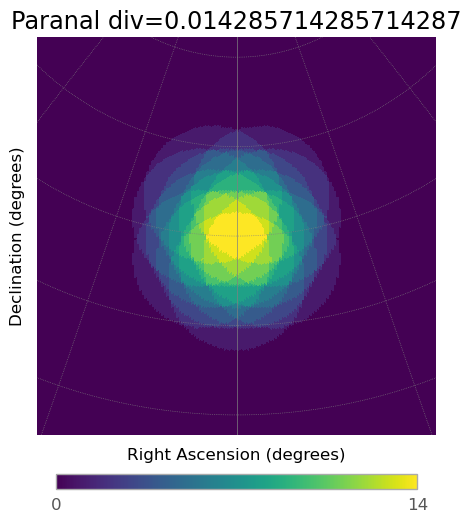

14it [00:01,  7.19it/s]
14it [00:01,  7.07it/s]


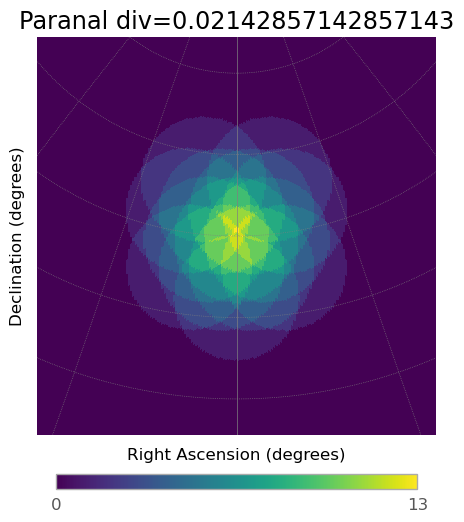

14it [00:01,  7.23it/s]
14it [00:01,  7.06it/s]


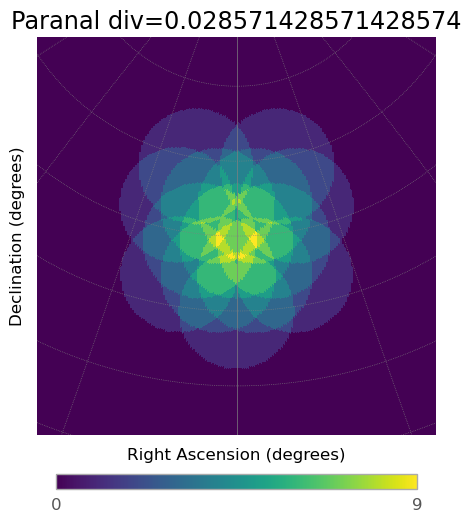

14it [00:01,  7.05it/s]
14it [00:01,  7.17it/s]


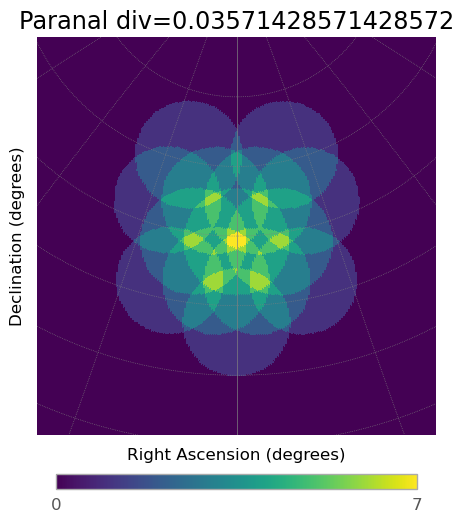

In [68]:
for divergence in stop_div:
    full_array.divergent_pointing(div=divergence, az=0, alt=70)
    full_array.multiplicity_plot()


4it [00:00,  7.14it/s]
4it [00:00,  6.96it/s]


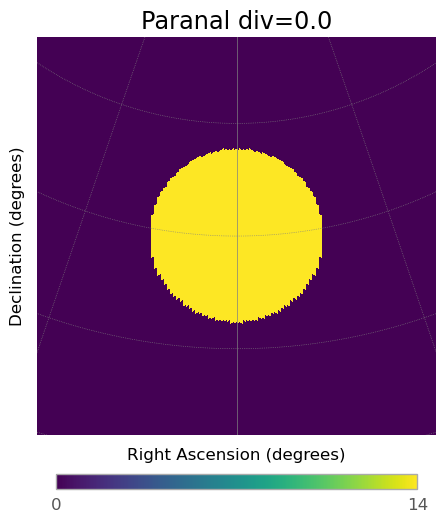

4it [00:00,  7.33it/s]
4it [00:00,  6.94it/s]


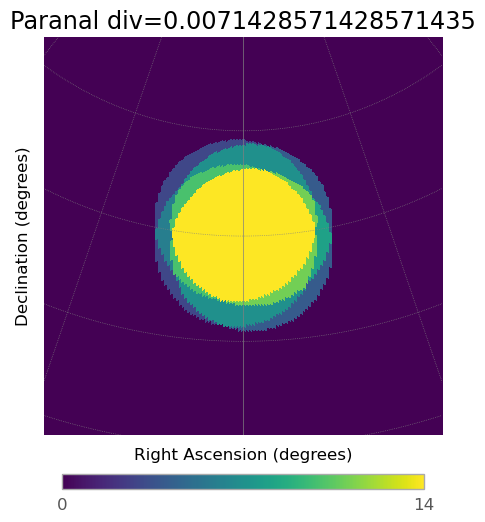

4it [00:00,  7.44it/s]
4it [00:00,  6.97it/s]


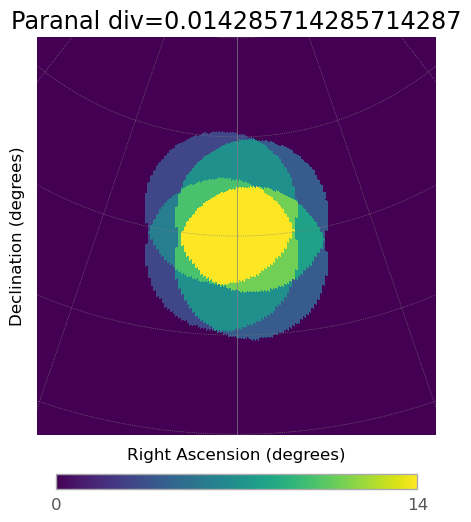

4it [00:00,  7.29it/s]
4it [00:00,  6.92it/s]


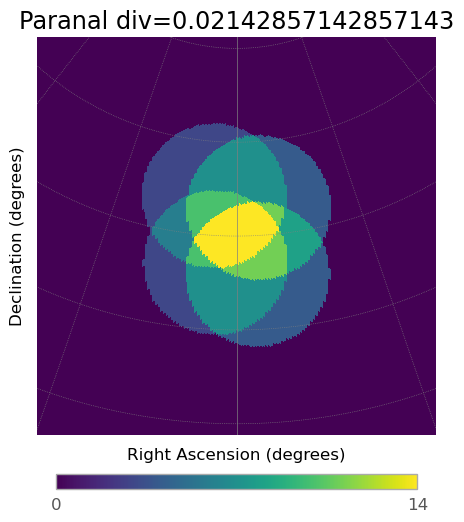

4it [00:00,  7.35it/s]
4it [00:00,  7.00it/s]


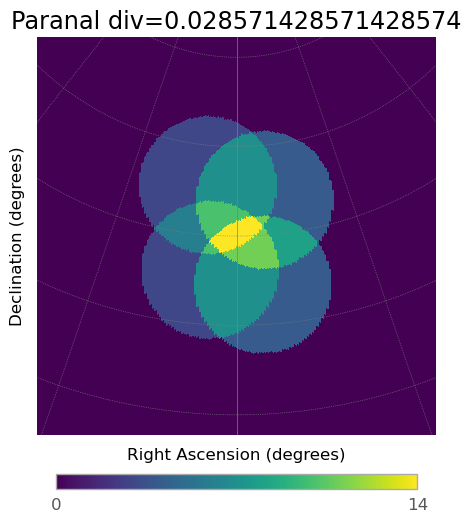

4it [00:00,  6.57it/s]
4it [00:00,  6.30it/s]


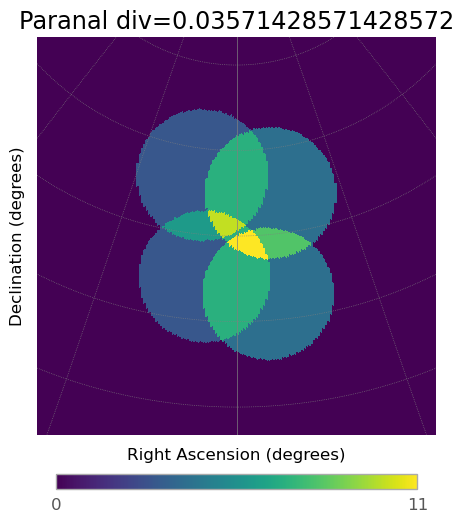

In [69]:
for divergence in stop_div:
    array.divergent_pointing(div=divergence, az=0, alt=70)
    array.multiplicity_plot(number_of_telescopes_subarray_1)

4it [00:00,  6.69it/s]
4it [00:00,  6.17it/s]


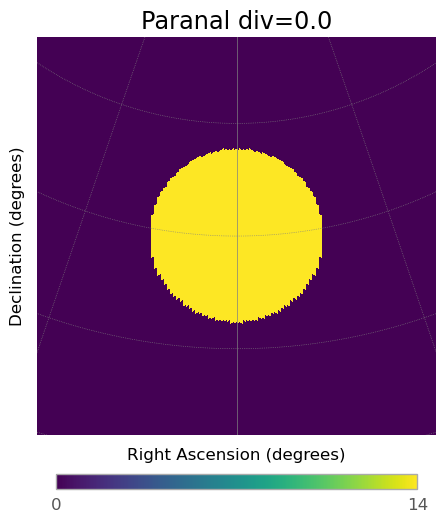

4it [00:00,  6.58it/s]
4it [00:00,  6.43it/s]


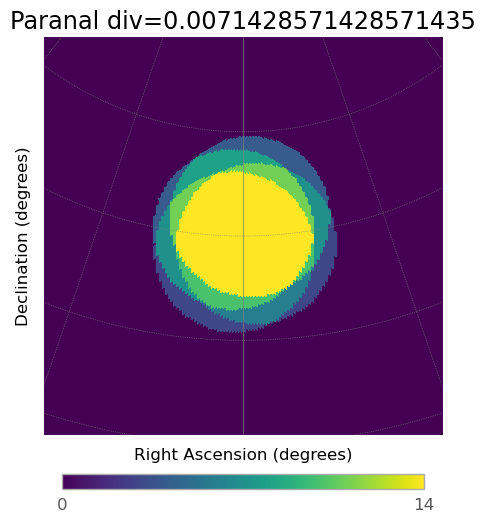

4it [00:00,  7.12it/s]
4it [00:00,  6.77it/s]


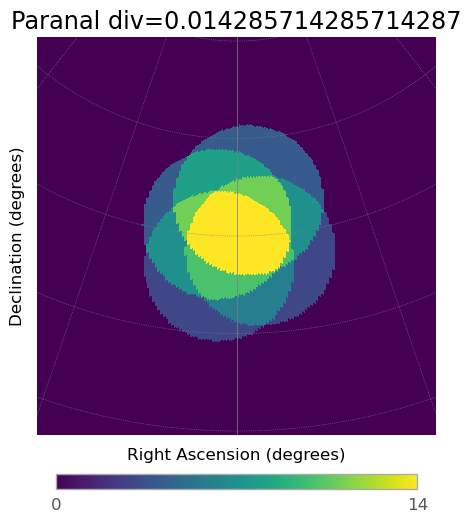

4it [00:00,  7.21it/s]
4it [00:00,  6.55it/s]


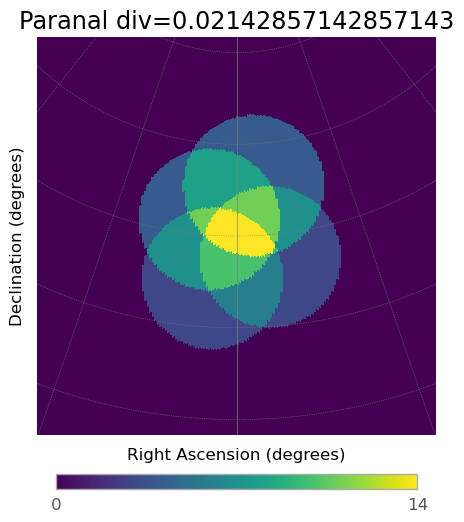

4it [00:00,  7.19it/s]
4it [00:00,  6.70it/s]


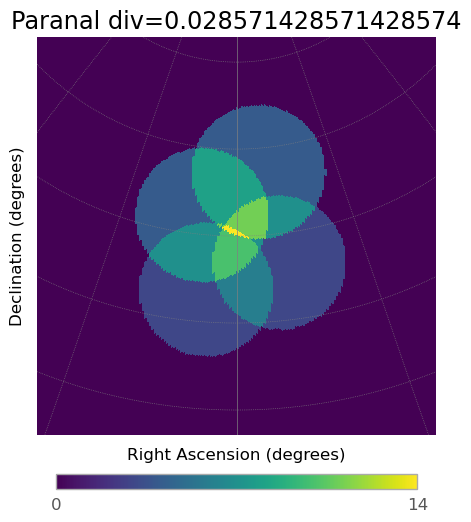

4it [00:00,  6.84it/s]
4it [00:00,  6.55it/s]


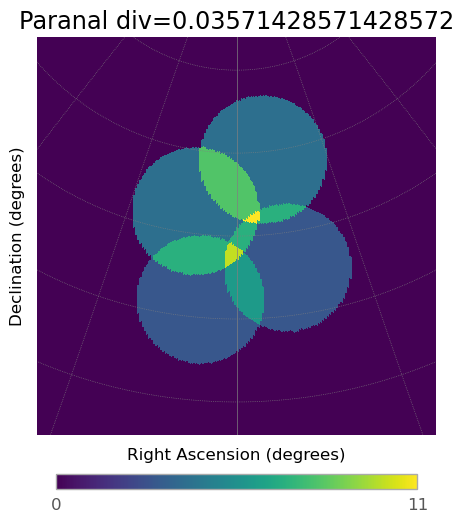

In [70]:
for divergence in stop_div:
    array_2.divergent_pointing(div=divergence, az=0, alt=70)
    array_2.multiplicity_plot(number_of_telescopes_subarray_2)

4it [00:00,  7.09it/s]
4it [00:00,  6.67it/s]


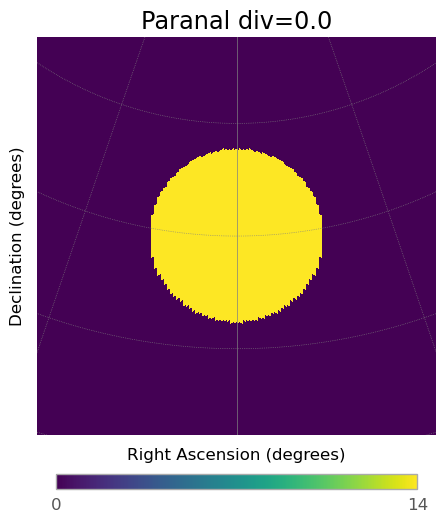

4it [00:00,  7.23it/s]
4it [00:00,  6.75it/s]


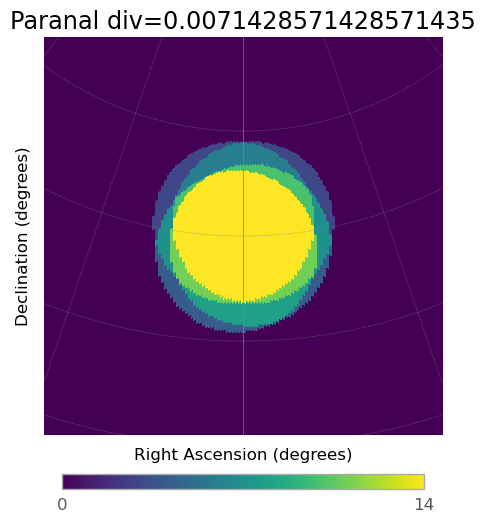

4it [00:00,  7.31it/s]
4it [00:00,  6.53it/s]


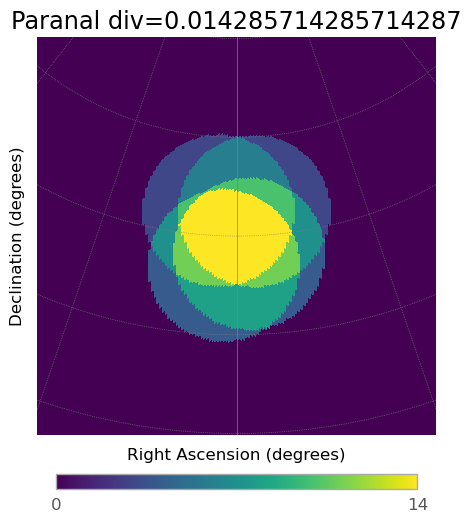

4it [00:00,  7.29it/s]
4it [00:00,  6.62it/s]


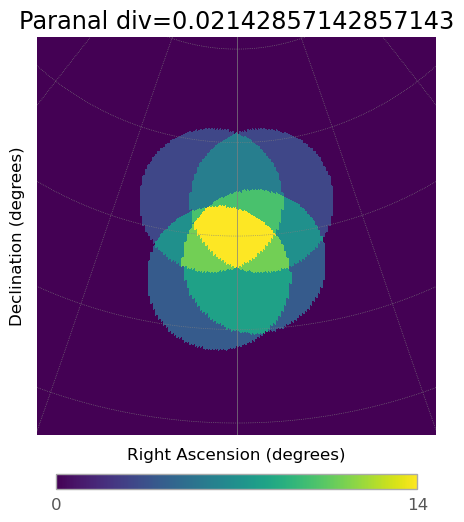

4it [00:00,  7.30it/s]
4it [00:00,  6.67it/s]


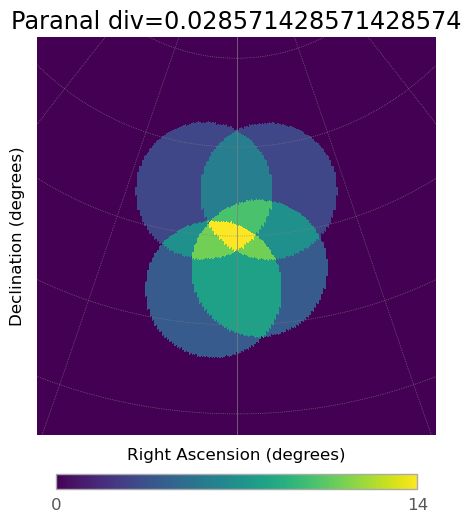

4it [00:00,  7.40it/s]
4it [00:00,  6.84it/s]


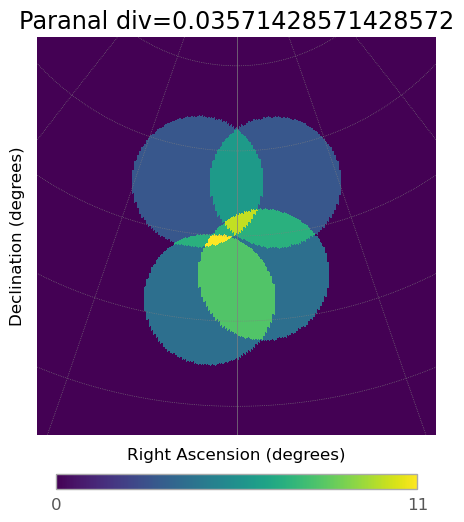

In [71]:
for divergence in stop_div:
    array_3.divergent_pointing(div=divergence, az=0, alt=70)
    array_3.multiplicity_plot(number_of_telescopes_subarray_3)

In [81]:
##Puting a different stop to the full the configuration 1 and configuration 2 
stop_sub_1_2_full=0.029 #From what we saw in the previous slides 
stop_div_sub_1_2_full=[]
for div in div_no_saturation_sub_1:
    print(div)
    if np.round(div,3) <= stop_sub_1_2_full: 
        stop_div_sub_1_2_full.append(div)
array_slice_stop_sub_1_2_full = np.size(stop_div_sub_1_2_full) #This is to slice the array

0.0
0.0071428571428571435
0.014285714285714287
0.02142857142857143
0.028571428571428574
0.03571428571428572
0.04285714285714286
0.05
0.05714285714285715
0.0642857142857143


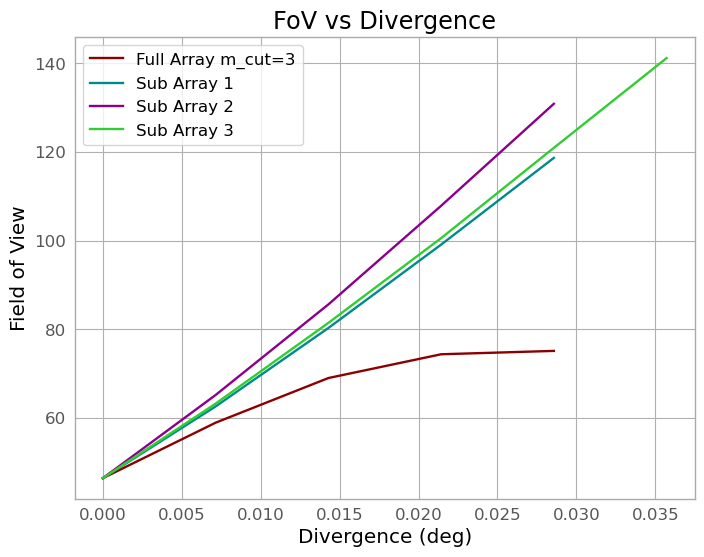

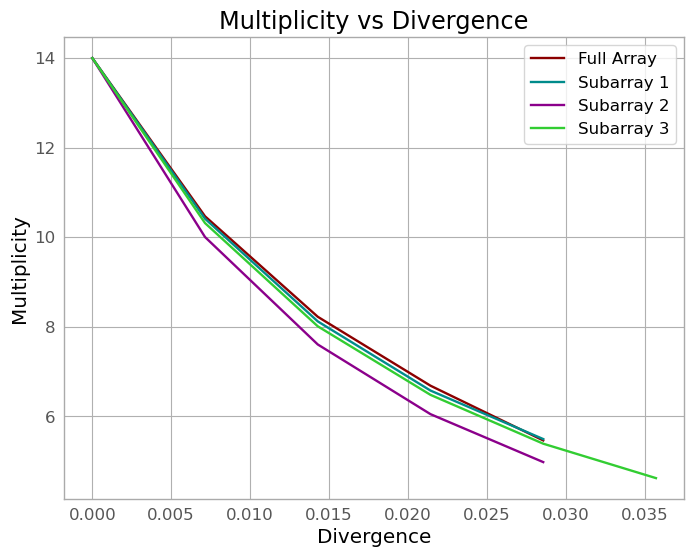

In [82]:
plt.plot(stop_div_sub_1_2_full, FoV_full_array[:array_slice_stop_sub_1_2_full], label='Full Array m_cut=3', color='darkred')
plt.plot(stop_div_sub_1_2_full, FoV_array[:array_slice_stop_sub_1_2_full], label='Sub Array 1', color='darkcyan')
plt.plot(stop_div_sub_1_2_full, FoV_array_2[:array_slice_stop_sub_1_2_full], label='Sub Array 2', color='darkmagenta')
plt.plot(stop_div, FoV_array_3[:array_slice_stop], label='Sub Array 3',color='limegreen')

# Add labels and title
plt.xlabel("Divergence (deg)")  
plt.ylabel("Field of View")  
plt.title("FoV vs Divergence")  

# Add legend
plt.legend()

# Display the plot
plt.show()
plt.plot(stop_div_sub_1_2_full, multiplicity_full_array[:array_slice_stop_sub_1_2_full], label='Full Array', color='darkred')
plt.plot(stop_div_sub_1_2_full,  multiplicity_array[:array_slice_stop_sub_1_2_full], label='Subarray 1', color='darkcyan')
plt.plot(stop_div_sub_1_2_full,  multiplicity_array_2[:array_slice_stop_sub_1_2_full], label='Subarray 2', color='darkmagenta')
plt.plot(stop_div,  multiplicity_array_3[:array_slice_stop], label='Subarray 3', color='limegreen')

plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

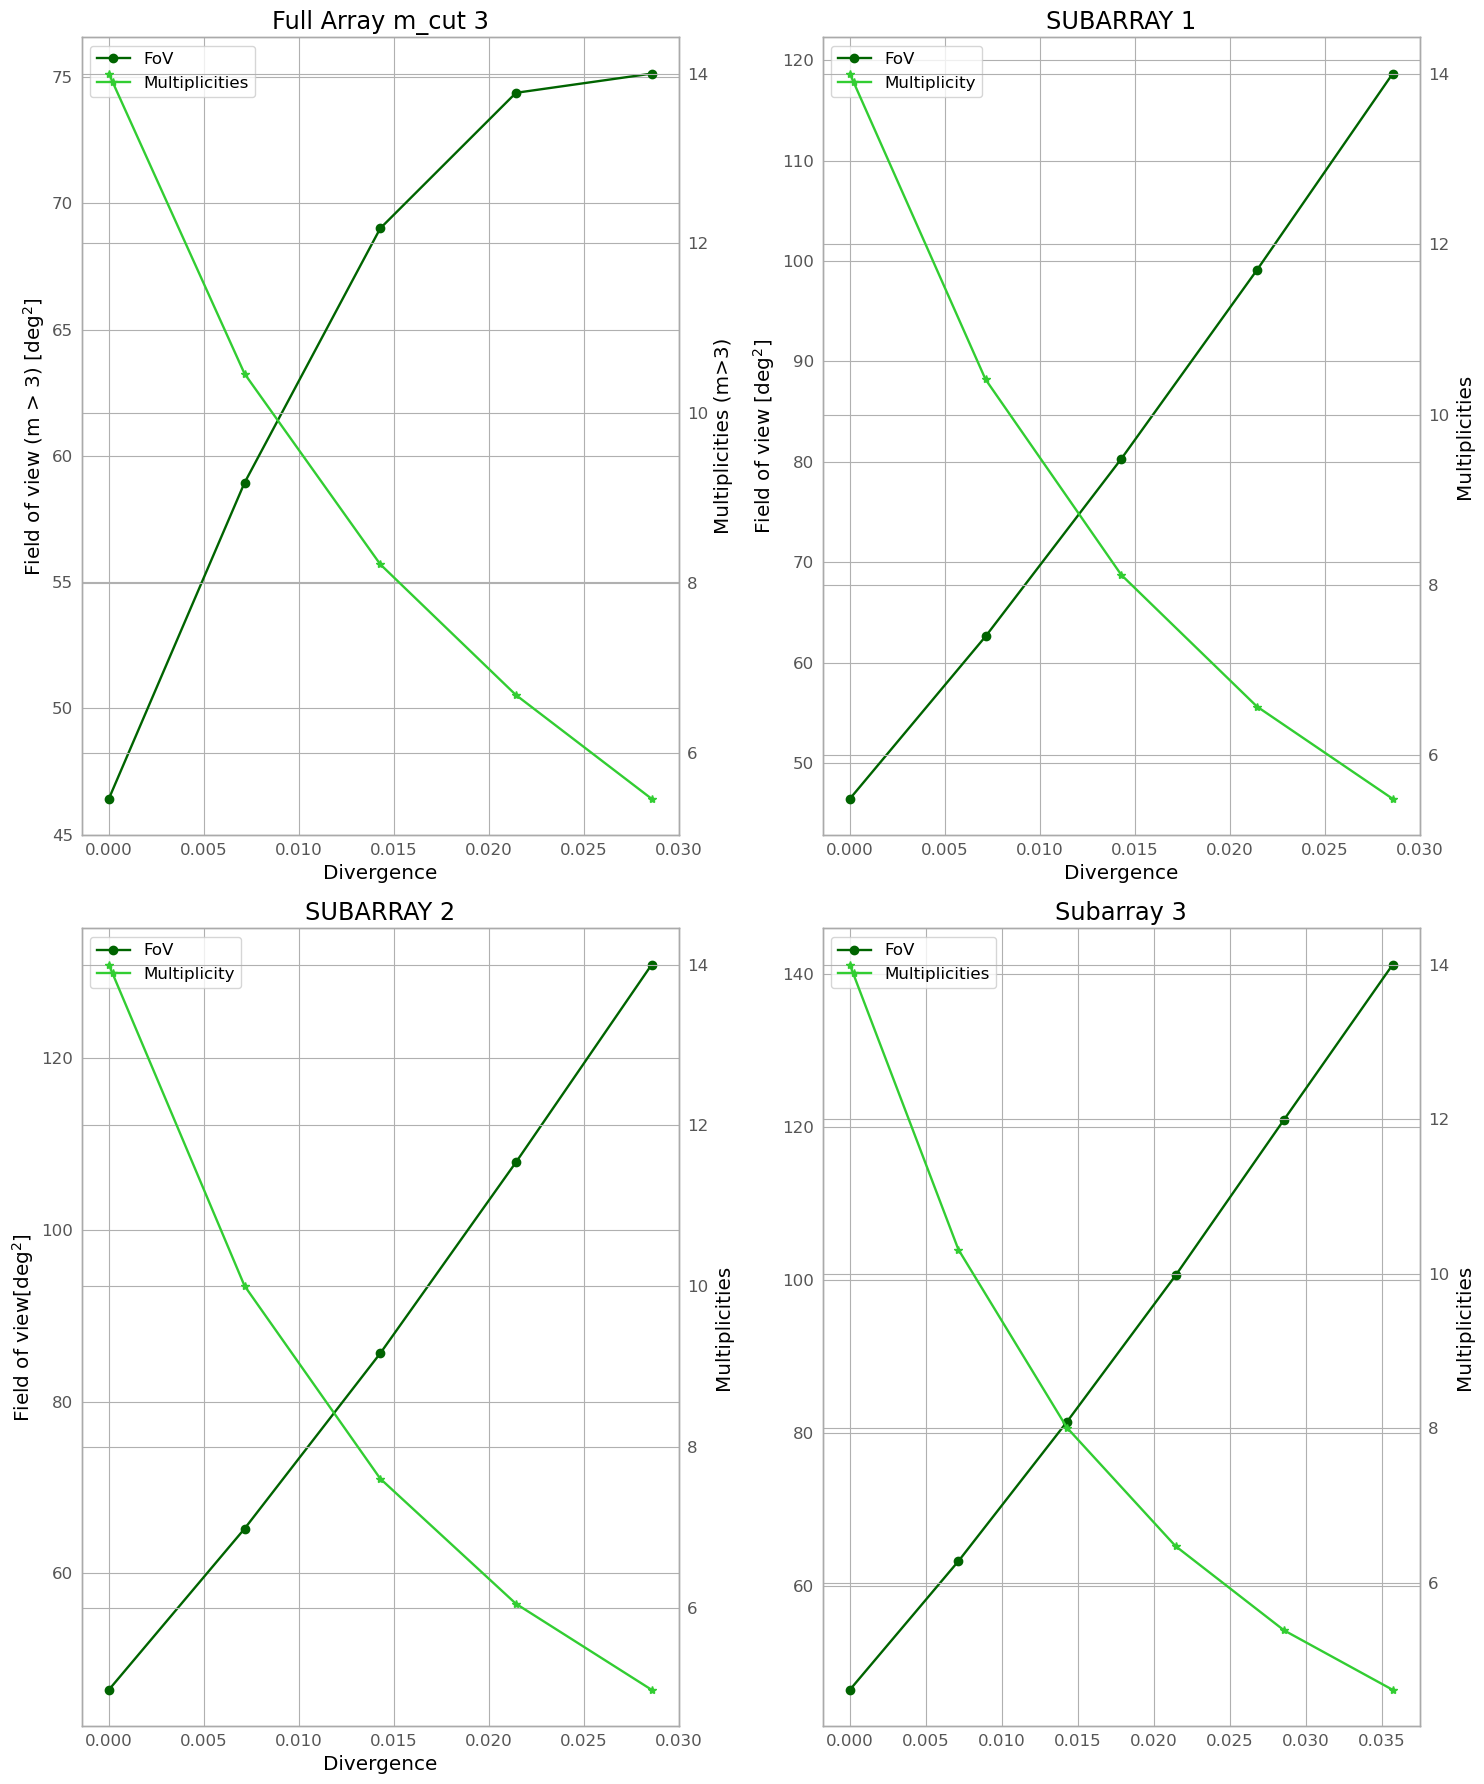

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(15, 18)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0,0].plot(stop_div_sub_1_2_full, FoV_full_array[:array_slice_stop_sub_1_2_full], label='FoV', marker='o', color='darkgreen')
ax2 = axes[0,0].twinx()
l2=ax2.plot(stop_div_sub_1_2_full, multiplicity_full_array[:array_slice_stop_sub_1_2_full], label='Multiplicities',marker='*', color='limegreen')
axes[0,0].set_title('Full Array m_cut 3')
axes[0,0].set_xlabel('Divergence')
axes[0,0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0,0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[0,1].plot(stop_div_sub_1_2_full, FoV_array[:array_slice_stop_sub_1_2_full], label='FoV',marker='o', color='darkgreen')
ax5=axes[0,1].twinx()
l2=ax5.plot(stop_div_sub_1_2_full, multiplicity_array[:array_slice_stop_sub_1_2_full], label='Multiplicity', marker='*', color='limegreen')
axes[0,1].set_title('SUBARRAY 1')
axes[0,1].set_xlabel('Divergence')
axes[0,1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[0,1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2
l1=axes[1,0].plot(stop_div_sub_1_2_full, FoV_array_2[:array_slice_stop_sub_1_2_full], label='FoV',marker='o', color='darkgreen')
ax5=axes[1,0].twinx()
l2=ax5.plot(stop_div_sub_1_2_full, multiplicity_array_2[:array_slice_stop_sub_1_2_full], label='Multiplicity', marker='*', color='limegreen')
axes[1,0].set_title('SUBARRAY 2')
axes[1,0].set_xlabel('Divergence')
axes[1,0].set_ylabel('Field of view[deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,0].legend(axeslegend, [l.get_label() for l in axeslegend])

# Subarray 3
l1=axes[1,1].plot(stop_div, FoV_array_3[:array_slice_stop], label='FoV',marker='o', color='darkgreen')
ax3 = axes[1,1].twinx()
l2=ax3.plot(stop_div,multiplicity_array_3[:array_slice_stop], label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 3')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()
# Subarray 4
#l1=axes[2,1].plot(stop_div, FoV_array_4[:array_slice_stop], label='FoV',marker='o', color='darkgreen')
#ax3 = axes[2,1].twinx()
#l2=ax3.plot(stop_div,multiplicity_array_4[:array_slice_stop], label='Multiplicities', marker='*', color='limegreen')
#plt.title('Subarray 4')
#plt.xlabel('Divergence')
#plt.ylabel('Field of view  [deg$^2$]')
#plt.ylabel('Multiplicities')
#axeslegend = l1+l2
#axes[2,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()


plt.show()

# How it changes with height

In [84]:
#If you do not do this like this but just put array_alt_1=array and array_alt_2=array you will end up with a problem
#You will end up having them over write each pther because they come from the same point
array_alt_1= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_1_div_2= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_1_div_3= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_2= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_2_div_2= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_2_div_3= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)

array_alt_3= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_3_div_2= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_3_div_3= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)

array_2_alt_1= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_1_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_1_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)

array_2_alt_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_2_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_2_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_3_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_3_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_1= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, poinitng2src=True)
array_3_alt_2= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, poinitng2src=True)
array_3_alt_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, poinitng2src=True)

array_4_alt_1=LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)
array_4_alt_2=LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)
array_4_alt_3=LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)

ValueError: no values provided to stack.

In [ ]:
altitude_array=[70,50,30]
az=0

In [ ]:
hFoV_altitude_1_configuration_1=[]
hFoV_altitude_2_configuration_1=[]
hFoV_altitude_3_configuration_1=[]
multiplicity_altitude_1_configuration_1=[]
multiplicity_altitude_2_configuration_1=[]
multiplicity_altitude_3_configuration_1=[]
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        array.multiplicity_plot(number_of_telescopes_subarray_1)
        

In [ ]:
hFoV_altitude_1_configuration_1=[]
hFoV_altitude_2_configuration_1=[]
hFoV_altitude_3_configuration_1=[]
multiplicity_altitude_1_configuration_1=[]
multiplicity_altitude_2_configuration_1=[]
multiplicity_altitude_3_configuration_1=[]
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        #array.multiplicity_plot(number_of_telescopes_subarray_1)
       
        

In [ ]:
hFoV_altitude_1_configuration_2=[]
hFoV_altitude_2_configuration_2=[]
hFoV_altitude_3_configuration_2=[]
multiplicity_altitude_1_configuration_2=[]
multiplicity_altitude_2_configuration_2=[]
multiplicity_altitude_3_configuration_2=[]
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array_2.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_2 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0])
            multiplicity_altitude_1_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0])
            multiplicity_altitude_2_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0])
            multiplicity_altitude_3_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1])
        array_2.multiplicity_plot(number_of_telescopes_subarray_2)
        

In [ ]:
hFoV_altitude_1_configuration_3=[]
hFoV_altitude_2_configuration_3=[]
hFoV_altitude_3_configuration_3=[]
multiplicity_altitude_1_configuration_3=[]
multiplicity_altitude_2_configuration_3=[]
multiplicity_altitude_3_configuration_3=[]
for divergence in stop_div:
    for alt in altitude_array:
        array_3.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_3 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0])
            multiplicity_altitude_1_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0])
            multiplicity_altitude_2_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0])
            multiplicity_altitude_3_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1])
        array_3.multiplicity_plot(number_of_telescopes_subarray_3)
        


In [ ]:
hFoV_altitude_1_configuration_4=[]
hFoV_altitude_2_configuration_4=[]
hFoV_altitude_3_configuration_4=[]
multiplicity_altitude_1_configuration_4=[]
multiplicity_altitude_2_configuration_4=[]
multiplicity_altitude_3_configuration_4=[]
for divergence in stop_div:
    for alt in altitude_array:
        array_4.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_4 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_4.hFoV(subarray_mult=number_of_telescopes_subarray_3))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0])
            multiplicity_altitude_1_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0])
            multiplicity_altitude_2_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0])
            multiplicity_altitude_3_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1])
        array_4.multiplicity_plot(number_of_telescopes_subarray_4)
        

In [ ]:
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

In [ ]:
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array_2.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_2 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

In [ ]:
for divergence in stop_div:
    for alt in altitude_array:
        array_3.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_3 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

In [ ]:
for divergence in stop_div:
    for alt in altitude_array:
        array_4.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_4 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

pointings90=[]
pointings70=[]
pointings50=[]
pointings30=[]
pointings0=[]
for alt in altitude_array:
        array.divergent_pointing(div=0.03, az=0, alt=alt)
        coord=array.get_pointing_coord(icrs=False)
        for i, tel in tqdm.tqdm(enumerate(array.telescopes)):
            if alt ==90:
                pointings90.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==70:
                pointings70.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==50:
                pointings50.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==30:
                pointings30.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==0:
                pointings0.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))

print(90, pointings90)
print(70, pointings70)
print(50, pointings50)
print(30, pointings30)
print(0, pointings0)

def SepAng(coords):
    normcoords=[]
    for i in range(len(coords)):
        normcoords.append(SkyCoord(ra=0, dec=coords[i].dec, unit='deg'))
    separations=[]
    for i in range(len(normcoords)):
        for t in range(len(normcoords)):
            if t>i:
                separations.append(normcoords[i].separation(normcoords[t]))
    return separations    
#separations=[]
#print(SepAng(pointings90))
print(SepAng(pointings70))
print(SepAng(pointings50))
print(SepAng(pointings30))
print(SepAng(pointings0))

pointingsRD=[]
for alt in altitude_array:
        pointingsRD.append('Altitude: {}'.format(alt))
        array.divergent_pointing(div=0.03, az=0, alt=alt)
        coord=array.get_pointing_coord(icrs=True)
        for i, tel in tqdm.tqdm(enumerate(array.telescopes)):
            #if alt ==altitude_array[0]:
            pointingsRD.append(SkyCoord(ra=coord.ra[i].degree, dec=coord.dec[i].degree, unit='deg'))

print(pointingsRD)

In [ ]:
plt.scatter(hFoV_altitude_1_configuration_4,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_4,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_4,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 4")  # Title of the plot
plt.legend()
plt.show()

In [ ]:
plt.scatter(hFoV_altitude_1_configuration_3,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_3,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_3,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 3")  
plt.legend()
plt.show()

In [ ]:
plt.scatter(hFoV_altitude_1_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 2")  # Title of the plot
plt.legend()
plt.show()

In [ ]:
plt.scatter(hFoV_altitude_1_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 1")  # Title of the plot
plt.legend()
plt.show()

In [ ]:
plt.scatter(multiplicity_altitude_1_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 1")  # Title of the plot
plt.legend()
plt.show()

In [ ]:
plt.scatter(multiplicity_altitude_1_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 2")  # Title of the plot
plt.legend()
plt.show()

In [ ]:
plt.scatter(multiplicity_altitude_1_configuration_3,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_3,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_3,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 3")  # Title of the plot
plt.legend()
plt.show()

In [ ]:
plt.scatter(multiplicity_altitude_1_configuration_4,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_4,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_4,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 4")  # Title of the plot
plt.legend()
plt.show()